In [1]:
using PyPlot

INFO: Loading help data...


2D Lattice Boltzmann (BGK) model of a fluid. D2Q9 model. Adapted from http://www.exolete.com/lbm/

Particle density
$$ \rho = \sum_{a=0}^8 f_a $$
where $f_a = \rho(v=e_a)$
macroscopic velocity
$$ u = \frac{1}{\rho} \sum_{a=0}^8 f_a e_a $$

In [29]:
#*
# configuration
#*
omega = 1.0;
density = 1.0;
fraction = 0.1 # average fraction of occupied nodes
radius = 5.

nx = 64;
ny = 32;

deltaU=1e-7;

#*
# setup of variables
#*
avu=1; prevavu=1;
ts=0;
avus = zeros(Float64, 40000)

# single-particle distribution function
# particle densities conditioned on one of the 9 possible velocities
F = repeat([density/9], outer= [nx, ny, 9]);
FEQ = F;
msize = nx*ny;
CI = [0:msize:msize*7]; # offsets of different directions e_a in the F matrix 

function setboundary()
    #BOUND = rand(nx,ny) .> 1 - fraction; # random domain
    center = [nx/2, ny/2]
    global BOUND = [norm([i, j]-center) < radius for i=1:nx, j=1:ny]
    global ON = find(BOUND); # matrix offset of each Occupied Node

    global numactivenodes=sum(sum(1-BOUND));

    # linear indices in F of occupied nodes
    global TO_REFLECT=[ON+CI[1] ON+CI[2] ON+CI[3] ON+CI[4] ON+CI[5] ON+CI[6] ON+CI[7] ON+CI[8]];

    # Right <-> Left: 1 <-> 5; Up <-> Down: 3 <-> 7
    #(1,1) <-> (-1,-1): 2 <-> 6; (1,-1) <-> (-1,1): 4 <-> 8
    global REFLECTED= [ON+CI[5] ON+CI[6] ON+CI[7] ON+CI[8] ON+CI[1] ON+CI[2] ON+CI[3] ON+CI[4]];
end

setboundary()
    
#*
# constants
#*
t1 = 4/9;
t2 = 1/9;
t3 = 1/36;
c_squ = 1/3;

#*
# main loop
#*
tic()
while ((ts<4000) & (1e-10 < abs((prevavu-avu)/avu))) | (ts<100)
    #*
    # Streaming
    #*
    # particles at (x,y)=[2,1] were at [1, 1] before: 1 points right (1,0)
    F[:,:,1] = F[[nx, 1:nx-1],:,1];
    # particles at [1,2] were at [1, 1] before: 3 points up (0,1)
    F[:,:,3] = F[:,[ny, 1:ny-1],3];
    # particles at [1,1] were at [2, 1] before: 5 points left (-1,0)
    F[:,:,5] = F[[2:nx, 1],:,5];
    # particles at [1,1] were at [1, 2] before: 7 points down (0,-1)
    F[:,:,7] = F[:,[2:ny, 1],7];
    
    # particles at [2,2] were at [1, 1] before: 2 points to (1,1)
    F[:,:,2] = F[[nx, 1:nx-1],[ny, 1:ny-1],2];
    # particles at [1,2] were at [2, 1] before: 4 points to (-1, 1)
    F[:,:,4] = F[[2:nx, 1],[ny, 1:ny-1],4];
    # particles at [1,1] were at [2, 2] before: 6 points to (-1, -1)
    F[:,:,6] = F[[2:nx, 1],[2:ny, 1],6];
    # particles at [2,1] were at [1, 2] before: 8 points down (1,-1)
    F[:,:,8] = F[[nx, 1:nx-1],[2:ny, 1],8];
    
    DENSITY = sum(F,3);
    
    # 1,2,8 are moving to the right, 4,5,6 to the left
    # 3, 7 and 9 don't move in the x direction
    global UX = (sum(F[:,:,[1, 2, 8]],3)-sum(F[:,:,[4, 5, 6]],3))./DENSITY;
    # 2,3,4 are moving up, 6,7,8 down
    # 1, 5 and 9 don't move in the y direction
    global UY = (sum(F[:,:,[2, 3, 4]],3)-sum(F[:,:,[6, 7, 8]],3))./DENSITY;
    
    UX[1,1:ny] = UX[1,1:ny] + deltaU; #Increase inlet pressure
    
    UX[ON] = 0; UY[ON] = 0; DENSITY[ON] = 0;
    
    U_SQU = UX.^2+UY.^2;
    U_C2 = UX+UY;
    U_C4 = -UX+UY;
    U_C6 = -U_C2;
    U_C8 = -U_C4;
    
    # Calculate equilibrium distribution: stationary (a = 0)
    FEQ[:,:,9] = t1*DENSITY.*(1-U_SQU/(2*c_squ));
    
    # nearest-neighbours
    FEQ[:,:,1] = t2*DENSITY.*(1+UX/c_squ+0.5*(UX/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,3] = t2*DENSITY.*(1+UY/c_squ+0.5*(UY/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,5] = t2*DENSITY.*(1-UX/c_squ+0.5*(UX/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,7] = t2*DENSITY.*(1-UY/c_squ+0.5*(UY/c_squ).^2-U_SQU/(2*c_squ));
    
    # next-nearest neighbours
    FEQ[:,:,2] = t3*DENSITY.*(1+U_C2/c_squ+0.5*(U_C2/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,4] = t3*DENSITY.*(1+U_C4/c_squ+0.5*(U_C4/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,6] = t3*DENSITY.*(1+U_C6/c_squ+0.5*(U_C6/c_squ).^2-U_SQU/(2*c_squ));
    FEQ[:,:,8] = t3*DENSITY.*(1+U_C8/c_squ+0.5*(U_C8/c_squ).^2-U_SQU/(2*c_squ));
    
    BOUNCEDBACK = F[TO_REFLECT]; #Densities bouncing back at next timestep
    
    F = omega*FEQ + (1-omega)*F;
    
    F[REFLECTED] = BOUNCEDBACK;
    
    prevavu = avu;
    avu = sum(sum(UX))/numactivenodes;
    avus[ts+1] = avu;
    ts = ts+1;
end
toc()

elapsed time: 9.915714007 seconds


9.915714007

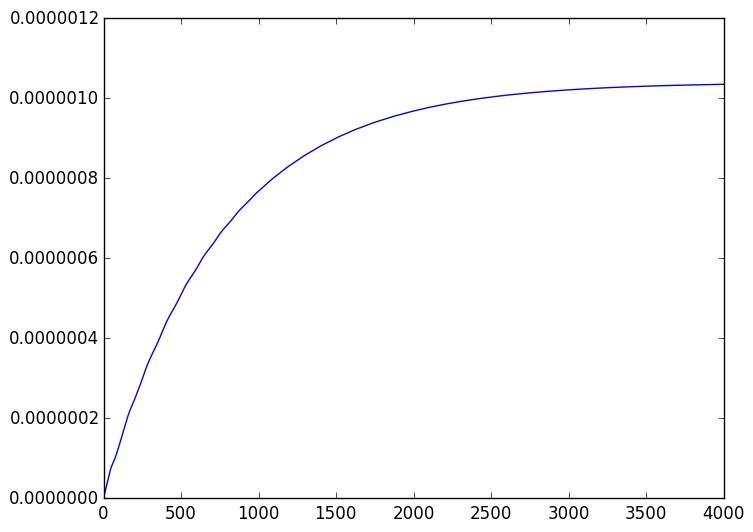

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe5a595c310>

In [30]:
plot(avus[1:ts])

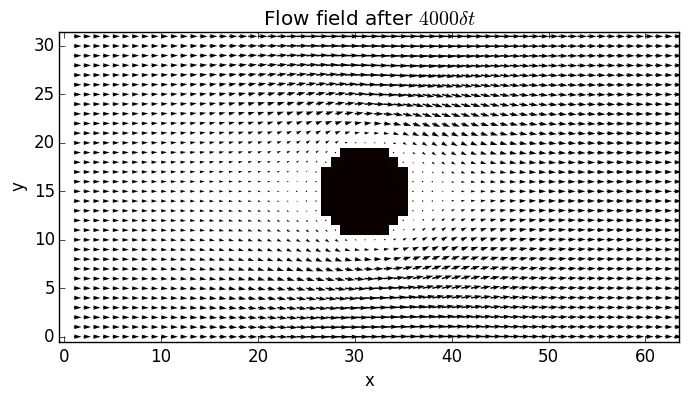

In [31]:
figure();
imshow(1-BOUND', cmap="hot", interpolation="None", vmin=0., vmax=1., origin="lower");
quiver(1:nx-1, 0:ny-1, UX[2:nx,:]', UY[2:nx,:]');
title(string("Flow field after \$ ", string(ts), " \\delta t\$"));
xlabel("x");
ylabel("y");